- delivery_CQ.csv        → main modeling table
- courier_trajectory_20s.csv → feature construction
- roads.csv              → structural constraints
- open-meteo             → exogenous weather
- delivery_five_cities   → metadata reference only


In [2]:
import pandas as pd

In [2]:
import pandas as pd
delivery_cq=pd.read_csv("../LaDe/delivery/delivery_cq.csv")
delivery_cq.head(10)

,order_id,region_id,city,courier_id,lng,lat,aoi_id,aoi_type,accept_time,accept_gps_time,accept_gps_lng,accept_gps_lat,delivery_time,delivery_gps_time,delivery_gps_lng,delivery_gps_lat,ds
0,2031782,10,Chongqing,73,108.71571,30.90228,50,14,10-22 10:26:00,10-22 10:26:00,108.71826,30.95587,10-22 17:04:00,10-22 17:04:00,108.66361,30.96702,1022
1,4285071,10,Chongqing,3605,108.71639,30.90269,50,14,09-07 10:13:00,09-07 10:13:00,108.71791,30.95635,09-09 15:44:00,09-09 15:44:00,108.71644,30.90266,907
2,4056800,10,Chongqing,3605,108.71645,30.90259,50,14,06-26 09:49:00,06-26 09:49:00,108.71798,30.95635,06-27 16:03:00,06-27 16:03:00,108.71647,30.90251,626
3,3589481,10,Chongqing,3605,108.71650,30.90347,50,14,09-11 11:01:00,09-11 11:01:00,108.71823,30.95596,09-13 17:14:00,09-13 17:14:00,108.71650,30.90341,911
4,2752329,10,Chongqing,3605,108.71608,30.90409,50,14,10-01 09:52:00,10-01 09:52:00,108.71820,30.95598,10-01 18:30:00,10-01 18:30:00,108.71413,30.90397,1001
5,659996,10,Chongqing,3605,108.71644,30.90470,50,14,08-08 19:01:00,08-08 19:01:00,108.71796,30.95630,08-11 10:50:00,08-11 10:50:00,108.71632,30.90479,808
6,4481765,10,Chongqing,3605,108.71605,30.90410,50,14,09-30 10:00:00,09-30 10:00:00,108.71824,30.95583,09-30 16:38:00,09-30 16:38:00,108.71429,30.90416,930
7,2365752,10,Chongqing,3605,108.71633,30.90266,50,14,09-30 10:00:00,09-30 10:00:00,108.71826,30.95585,09-30 18:38:00,09-30 18:38:00,108.71425,30.90416,930
8,20671,10,Chongqing,3605,108.71643,30.90253,50,14,05-20 10:06:00,05-20 10:06:00,108.71795,30.95621,05-21 15:30:00,05-21 15:30:00,108.71643,30.90250,520
9,965648,10,Chongqing,3605,108.71554,30.90256,50,14,08-10 10:52:00,08-10 10:52:00,108.71797,30.95630,08-12 15:50:00,08-12 15:50:00,108.71542,30.90243,810


In [3]:
print(f'Columns are : { delivery_cq.columns}')

Columns are : Index(['order_id', 'region_id', 'city', 'courier_id', 'lng', 'lat', 'aoi_id',
       'aoi_type', 'accept_time', 'accept_gps_time', 'accept_gps_lng',
       'accept_gps_lat', 'delivery_time', 'delivery_gps_time',
       'delivery_gps_lng', 'delivery_gps_lat', 'ds'],
      dtype='object')


## Explaining the datapoints 

- order_id → Unique identifier for each package. Use: Links courier events to specific deliveries.
- region_id → Region identifier within the city. Use: Helps model local traffic patterns.
- city → City name (Shanghai, Hangzhou, etc.). Use: Context for traffic and urban layout.
- courier_id → Unique identifier for the courier. Use: Allows modelling courier‑specific efficiency or speed.
- 'lng', 'lat' Coordinates of each stop in a 2D space (longitude/latitude). Use: Defines delivery/pickup locations.

- aoi_id → Area of Interest ID (e.g., residential complex, office building). Use: Delivery zone granularity. numbers ~ 1700 

- aoi_type → Type of AOI (residential, commercial, etc.). Use: Captures congestion differences (e.g., office vs. housing).

- accept_time → Time when courier accepts the task. Use: Start of ETA clock.

- acceptgps_time → GPS timestamp closest to accept_time. Use: Synchronizes courier’s location with task acceptance.

-  acceptgpsx/acceptgpsy Coordinates when the courier accept the task

- deliverytime → Time when courier finishes delivery. Use: Ground truth ETA.

- deliverygps_time → GPS timestamp closest to deliverytime. Use: Synchronizes courier’s location with delivery completion.

- delivery_gps_lng', 'delivery_gps_lat' → Courier’s coordinates at delivery. Use: Endpoint for route reconstruction.

- ds → Date of package delivery. Use: Enables modelling of temporal patterns (weekday vs. weekend, seasonal effects).




Ground truth ETA = deliverytime – accept_time.

Route reconstruction = acceptgpsx/y → deliverygpsx/y snapped to roads.csv.

Features for ML models:

Spatial: x/y, regionid, aoi_type.

Temporal: accept_time, deliverytime, ds.

Courier behavior: courier_id.

Context: city.

###########################################

# Using delivery & roads 

- accept_gps_lng/lat and delivery_gps_lng/lat from delivery.csv are raw GPS points. Snap these points to the nearest road segments in roads.csv using the geometry column. idea is to align courier trajectories to real road 

- Once endpoints are snapped, we can reconstruct the likely path through the road graph (osm_id, fclass, oneway).

This gives us the actual route taken instead of just straight‑line GPS.

- Use geometry in roads.csv to compute road segment lengths.

- Sum segment lengths along the reconstructed route → total travel distance.

- Combine distance with maxspeed and fclass from roads.csv to estimate travel time.

- Compare with actual delivery_time – accept_time in delivery.csv → ground truth ETA.

- Road attributes (fclass, oneway, bridge, tunnel) become features that explain why some deliveries are faster/slower.

- Delivery context (city, aoi_type, courier_id) adds behavioral and urban traffic variation.




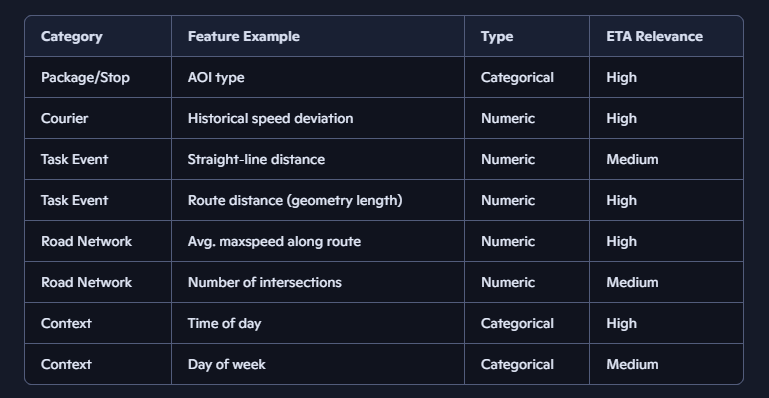

weather data by ERA5 reanalysis (Copernicus)

Download gridded weather data (NetCDF/CSV).

Join by city + ds + accept_time to enrich each delivery row with weather features.

# traffic info 
https://developer.tomtom.com/traffic-stats/documentation/api/traffic-density

https://www.ceicdata.com/en/china/highway-traffic-mobility-trends-real-index-departure-shanghai


# DELIVERY_5_CITIES.PKL

- global, city-agnostic order metadata table
- maps: 1) order_id → aoi_id  2) aoi_id → typecode 3)order_id → from_city_name across all 5 cities.

#####################################

| Column                       | Meaning                                 |
| ---------------------------- | --------------------------------------- |
| `order_id`                   | Unique order identifier                 |
| `from_dipan_id`              | Origin hub / dispatch point ID          |
| `from_city_name`             | City name (string, Chinese)             |
| `delivery_user_id`           | Courier ID                              |
| `poi_lng`, `poi_lat`         | Destination POI (projected coordinates) |
| `aoi_id`                     | Area-of-Interest identifier             |
| `typecode`                   | POI / AOI category (building type)      |
| `receipt_time`               | Order creation / customer receipt time  |
| `receipt_lng`, `receipt_lat` | Customer location at receipt            |
| `sign_time`                  | Delivery completion time                |
| `sign_lng`, `sign_lat`       | Delivery GPS (often missing)            |
| `ds`                         | Date code (month-day)                   |


In [3]:
d5c_df=pd.read_pickle("../LaDe/data_with_trajectory_20s/delivery_five_cities.pkl.xz",compression='xz')
d5c_df.head(7)

,order_id,from_dipan_id,from_city_name,delivery_user_id,poi_lng,poi_lat,aoi_id,typecode,receipt_time,receipt_lng,receipt_lat,sign_time,sign_lng,sign_lat,ds
0,e4025a4e91d062078ff720f33d1a2499,39dbc318137dabd3a179db2568cdb3c0,上海市,a44530f407351f27387e3ddcd5e69bad,1.112229e+07,-6.484431e+06,4ca5f674a8328cb39f06c96b654e7526,203ac3454d75e02ebb0a3c6f51d735e4,04-06 12:23:00,1.112023e+07,-6.486854e+06,04-06 19:48:00,NaN,NaN,406
1,4624c7e9f426322aada2624af1ba7576,1f0a71b10716d45e756500b4eda7ed29,重庆市,16f61052692854242cd3ffc22322b55d,9.476296e+06,-6.698616e+06,f62d32f12bebee010b413e9dc0e8cd4c,203ac3454d75e02ebb0a3c6f51d735e4,04-06 13:48:00,9.478114e+06,-6.699246e+06,04-06 14:37:00,NaN,NaN,406
2,71c90a616b9a480ba0fab7ca12266496,fe4b0880307873de265970ba5d0128d2,重庆市,dcef1caf39ac2a89e899254ea5af6d3e,9.478885e+06,-6.703250e+06,abe3337e6c88ead985497414b6b5097e,203ac3454d75e02ebb0a3c6f51d735e4,04-06 08:17:00,9.478612e+06,-6.703903e+06,04-06 13:16:00,NaN,NaN,406
3,9dda05bea9bb832d4de17e7c72c12f30,37e976ad4abb10da92c97c6b34f7f54f,重庆市,a35804dfb707a25a8d9705d9a476d5d1,9.473298e+06,-6.698757e+06,7d2f997f860e426f3f46e120ee436702,203ac3454d75e02ebb0a3c6f51d735e4,04-06 08:30:00,9.473343e+06,-6.697663e+06,04-06 12:39:00,NaN,NaN,406
4,d3404240b5b69e03d4ba34a37fb75f6d,54d59540382d1e5b18c05c2179b1c533,重庆市,14d24c2dd8732d67b1e854c9f1367b61,9.466900e+06,-6.694510e+06,4c5b643a467c1efa1a2ddf067cf275a6,4602b38053ece07a9ca5153f1df2e404,04-06 17:36:00,9.469849e+06,-6.691360e+06,04-19 09:38:00,NaN,NaN,406
5,0ad21313ada79df2696fb4decde3ee2c,1d38fe6f1c02d1823402c53b846a54fb,上海市,ec227db3ed8730116bcb065b4b47d835,1.113493e+07,-6.482164e+06,98440cc45f867e4754b46583e1c27e38,203ac3454d75e02ebb0a3c6f51d735e4,04-06 11:08:00,1.113488e+07,-6.481627e+06,04-06 12:29:00,NaN,NaN,406
6,e539e1934f1739d5055f357aeb47ab24,7ad7cdb1b926902ba6af499fd22a1792,重庆市,b56ab5f495af883fda287b6e15b2a145,9.479577e+06,-6.693010e+06,a5440699e148475b5b6d0cb9ccff69bd,203ac3454d75e02ebb0a3c6f51d735e4,04-06 14:20:00,9.480216e+06,-6.692686e+06,04-06 15:49:00,NaN,NaN,406


In [ ]:
d5c_df['from_city_name'].unique()

# In delivery 5 cities metadata table , data is present only for 3 cities Shanghai, Chongqing, Hangzhou

- delivery_user_id matches with postman_id between delivery5cities and 20s sampling data

In [4]:
deliveryseq_mother=pd.read_csv("../LaDe/courier_detailed_trajectory/courier_detailed_trajectory.csv")
print(f"Starting range of date : {deliveryseq_mother['ds'].max()} | {deliveryseq_mother['ds'].min()}")

Starting range of date : 401 | 318


In [6]:
deliveryseq_mother.head()

,ds,postman_id,gps_time,lat,lng
0,318,01890dd2fdc077b8deb7d8c120bf9c9f,03-18 00:01:04,2.375271e+06,1.566731e+06
1,318,01890dd2fdc077b8deb7d8c120bf9c9f,03-18 00:16:04,2.375280e+06,1.566754e+06
2,318,01890dd2fdc077b8deb7d8c120bf9c9f,03-18 00:31:04,2.375273e+06,1.566753e+06
3,318,01890dd2fdc077b8deb7d8c120bf9c9f,03-18 00:46:04,2.375286e+06,1.566753e+06
4,318,01890dd2fdc077b8deb7d8c120bf9c9f,03-18 01:01:04,2.375268e+06,1.566753e+06


In [5]:
deliveryseq_mother['from_city_name'].unique()

KeyError: 'from_city_name'

# roads.csv 



In [4]:
road_df=pd.read_csv("../LaDe/road-network/roads.csv",sep="\t")
unique_vals = road_df['city'].unique()        # numpy array
unique_list = road_df['city'].dropna().unique().tolist()
counts = road_df['city'].value_counts() 

print(f'Unique cities present in the dataset are : {unique_vals}')
print(f'Count of individual cities \n: {counts}')

CITY_LITERAL_MAP = {
    "杭州市": "Hangzhou",
    "吉林市": "Jilin",
    "上海市": "Shanghai",
    "烟台市": "Yantai",
    "重庆市": "Chongqing",
}

def translate_and_update(df: pd.DataFrame, col: str = "city") -> pd.DataFrame:
    """
    Replace values in `col` with literal English translations using CITY_LITERAL_MAP,
    and create a new column 'city_chinese' containing the original Chinese values.
    Unknown values are left as-is in 'city_chinese' and mapped to empty string in 'city'.
    """
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in DataFrame")

    # Create city_chinese column as copy with the original values
    df["city_chinese"] = df[col].astype(object)

    # Map to English literal names, use empty string for unmapped entries
    df[col] = df[col].map(CITY_LITERAL_MAP).fillna("")

    return df


original_road_df = road_df.copy(deep=True)

road_df = translate_and_update(road_df, "city")
print(road_df.head(5))

road_df.to_csv("../processed/roads_translated_motherfile.csv", index=False)

Unique cities present in the dataset are : ['杭州市' '吉林市' '上海市' '烟台市' '重庆市']
Count of individual cities 
: city
上海市    163237
烟台市    128098
重庆市    121976
杭州市     97881
吉林市     20088
Name: count, dtype: int64
    osm_id  code     fclass  name  ref oneway  maxspeed  layer bridge tunnel  \
0  4296533  5141    service   NaN  NaN      B         0      0      F      F   
1  4296592  5115   tertiary   朝晖路  NaN      B         0      0      F      F   
2  4298707  5114  secondary  体育场路  NaN      F         0      0      F      F   
3  4298708  5113    primary   大关路  NaN      F         0      0      F      F   
4  4305243  5114  secondary  建国北路  NaN      F         0      0      F      F   

       city                                           geometry city_chinese  
0  Hangzhou  LINESTRING (13373499.140421594 3538916.2947984...          杭州市  
1  Hangzhou  LINESTRING (13376291.100042382 3539415.0794264...          杭州市  
2  Hangzhou  LINESTRING (13375063.92510783 3538697.18123532...          杭州市  
3

In [ ]:
def compare_city_counts(original_df: pd.DataFrame, new_df: pd.DataFrame, col_original: str = "city", col_new: str = "city") -> pd.DataFrame:
    """
    Compare value counts between original and new DataFrame city columns.
    - original_df: DataFrame before translation (should have original Chinese values)
    - new_df: DataFrame after translation (city column contains English; original Chinese kept elsewhere)
    - col_original: column name in original_df to count (default "city")
    - col_new: column name in new_df to count (default "city")
    Returns a DataFrame with columns: key, count_original, count_new, diff (new - original).
    """
    # compute counts
    orig_counts = original_df[col_original].value_counts(dropna=False).rename("count_original")
    new_counts = new_df[col_new].value_counts(dropna=False).rename("count_new")
    # align index (union of keys)
    combined = pd.concat([orig_counts, new_counts], axis=1).fillna(0).astype(int)
    combined["diff"] = combined["count_new"] - combined["count_original"]
    combined.index.name = "city"
    combined = combined.reset_index()
    return combined


summary = compare_city_counts(original_road_df, road_df, col_original="city", col_new="city_chinese")
print(summary.sort_values(by="count_original", ascending=False).to_string(index=False))

In [ ]:
# Assume you have: trajectory_20s.csv with columns:
# [courier_id, timestamp, lng, lat, packageid]

import pandas as pd
import numpy as np

# Load trajectory data
traj_df = pd.read_csv('trajectory_20s.csv')
traj_df['timestamp'] = pd.to_datetime(traj_df['timestamp'])

# For each delivery (packageid), calculate trajectory features
def compute_trajectory_features(package_traj):
    """
    Extract features from a single package's GPS trajectory
    """
    # Sort by time
    package_traj = package_traj.sort_values('timestamp')
    
    features = {}
    
    # 1. ACTUAL DISTANCE TRAVELED (sum of segments)
    coords = package_traj[['lng', 'lat']].values
    distances = np.sqrt(np.sum(np.diff(coords, axis=0)**2, axis=1))
    features['actual_distance'] = np.sum(distances)
    
    # 2. ROUTE EFFICIENCY (straightline distance / actual distance)
    start = coords[0]
    end = coords[-1]
    straightline_dist = np.sqrt(np.sum((end - start)**2))
    features['route_efficiency'] = straightline_dist / (features['actual_distance'] + 1e-6)
    
    # 3. AVERAGE SPEED
    time_diffs = np.diff(package_traj['timestamp'].values).astype('timedelta64[s]').astype(float)
    speeds = distances / (time_diffs + 1e-6)  # meters per second
    features['avg_speed'] = np.mean(speeds)
    features['max_speed'] = np.max(speeds)
    features['min_speed'] = np.min(speeds)
    
    # 4. SPEED VARIANCE (traffic indicator)
    features['speed_variance'] = np.var(speeds)
    features['speed_std'] = np.std(speeds)
    
    # 5. NUMBER OF STOPS (speed < threshold)
    stop_threshold = 0.5  # m/s
    features['n_stops'] = np.sum(speeds < stop_threshold)
    features['total_stop_time'] = np.sum(time_diffs[speeds < stop_threshold])
    
    # 6. ROUTE COMPLEXITY (number of direction changes)
    if len(coords) > 2:
        vectors = np.diff(coords, axis=0)
        angles = np.arctan2(vectors[:, 1], vectors[:, 0])
        angle_changes = np.abs(np.diff(angles))
        features['n_turns'] = np.sum(angle_changes > np.pi/4)  # 45-degree threshold
        features['route_tortuosity'] = np.sum(angle_changes)
    
    # 7. WAITING TIME (time when speed ≈ 0)
    features['waiting_time'] = np.sum(time_diffs[speeds < 0.1])
    
    return features

# Group by package and compute features
trajectory_features = traj_df.groupby('packageid').apply(
    compute_trajectory_features
).apply(pd.Series)

# Merge with main delivery data
df_all = df_all.merge(trajectory_features, left_on='packageid', right_index=True, how='left')